# Variational Quantum Eigensolver Tutorial
### James Saslow
### 11/10/2023

# Introduction


This project serves as a tutorial for programming the Variational Quantum Eigensolver (VQE), a valuable quantum chemistry algorithm in Python. The VQE is a hybrid classical - quantum algorithm that attempts to find the ground state energy of some molecule. It computes the expectation value of the energy through a quantum circuit, and then minimizes this value with classical computing methods. So far, VQE is able to solve for the ground state of small, simple molecules such as Dihydrogen ($H_{2}$), the Helium Hydride Ion ($HeH^{+}$), and the Beryllium Hydride molecule ($BeH_{2}$). VQE has trouble computing ground state energies of bigger, more complex molecules at the moment because of current quantum hardware limitations. 
The number of qubits required to compute the ground state of some molecule scales with the Hilbert space of that molecule.
Implementing a large amount of qubits that are noise resilient on quantum devices continues to be the bottleneck of quantum computing. Unfortunately, we won't be able to conduct VQE of complex molecules until quantum engineers make the necesary hardware breakthroughs needed to fully realize quantum computing. In the meantime, we have fun, tiny molecules to play with and perform and test the VQE on! In particular, contemporary quantum computers can only calculate simple molecules with a computational Hilbert space described by only a few qubits (2-3). this interactive notebook presents a surface-level tutorial of implementing the VQE, the theory behind it, and it's performance in solving the $H_{2}$ molecule. 


The VQE algorithm contains 5 parts:

- 1) Translate the Hamiltonian of the molecule from the fermion basis to the computational basis

- 2) Define a unitary ansatz $\mathscr{U}$ to make some parameterized wavefunction $\mathscr{U}|01>$

- 3) Write the unitary ansatz as a series of quantum gates (any unitary matrix can be written in terms of other unitaries)

- 4) 'Measure' the Energy Expectation value

- 5 ) Optimize the parametrized unitary with the goal of minimizing $<E>$ since $<E> \; \geq E_{ground}$
    - If $<E>$ is sufficiently minimized, then $<E> \approx E_{ground}$
    - We can minimize $<E>$ through some optimizer i.e. gradient descent

All 5 parts of the VQE will be closely investigated, implimented, and explained in this tutorial.

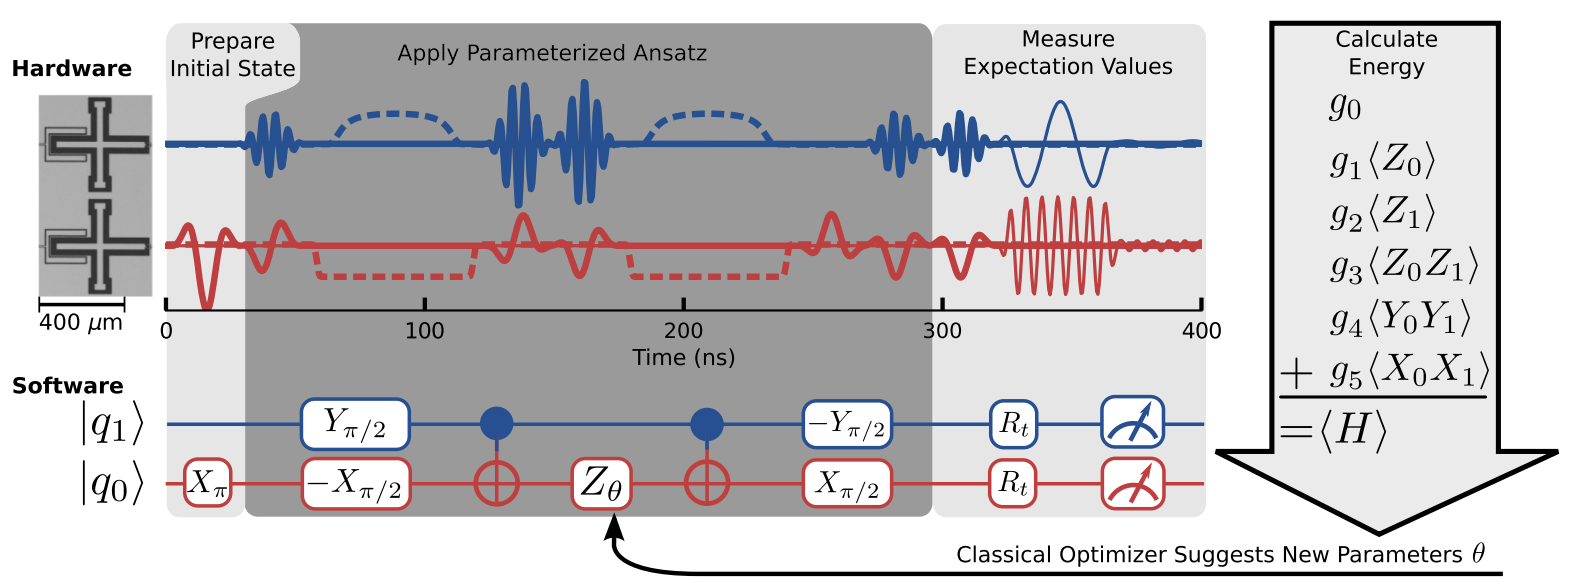

*Hardware and software schematic of the VQE from [5]*

In [2]:
# Importing Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile
from qiskit.providers.aer import AerSimulator
S_simulator = Aer.backends(name='statevector_simulator')[0]


# My custom Qiskit Package (Included in zip file => Qfuncs2.py)
import Qfuncs2 as qf

# $\underline{1) \; Writing \; the \; Hamiltonian \; in \; the \; Computational \; Basis}$

### Translating the Hamiltonian from the Fermion Basis to the Computational Basis


The Hamiltonian in the Fermion basis is typically expressed as the sum of kinetic energy $\hat{T}$ and potential energy parts $\hat{V}$. Assuming stationary nuclei, we can assume a completely electronic Hamiltonian.


$\hat{T} = -\sum_{i}^{n_{e}} \frac{\hbar^{2}}{2 m_{e}} \nabla_{i}^{2} $ (Kinetic Energy of electrons)


$\hat{V} = \sum_{i,j}^{n_{e}} \frac{e^{2}}{4\pi\epsilon_{0} |r_{i} - r_{j}|} - \sum_{i}^{n_{e}} \sum_{j}^{n_{p}} \frac{Z_{j} e^{2}}{4\pi\epsilon_{0} |r_{i} - r_{j}|}$ 
(electron - electron repulsion + electron-proton attraction)

Thus, the fermionic Hamiltonian looks like 

$\hat{H} = \hat{T} + \hat{V}$

But we would like to do either a Jordan-Wigner (JW) transformation or a Bravyi-Kitaev (BK) to translate the fermionic Hamiltonian of $H_{2}$ in terms of quantum computing gates. It turns out, we can do a BK transformation to write the Hamiltonian of $H_{2}$ in the computational basis in terms of just 2 qubits! The resultant computational Hamiltonian for $H_{2}$ is shown below in $\textbf{Implementing Useful Information from [1]}$

### Coding up the Usual Quantum Gates

In [3]:
# Defining our usual quantum gates as matrices

#========= Single Qubit Gates ==========

# Identity
I = np.array([[1,0],
              [0,1]])

# Not Gate
X = np.array([[0,1],
              [1,0]])

# Y Gate
Y = np.array([[0,-1j],
              [1j,0]])

# Z Gate
Z = np.array([[1,0],
              [0,-1]])

#========= Double Qubit Gates ==========
# (x) = Tensor Product symbol

II = np.kron(I,I) # I0 (x) I1 Gate
Z0 = np.kron(Z,I) # Z0 (x) I1 Gate
Z1 = np.kron(I,Z) # I0 (x) Z1 Gate
ZZ = np.kron(Z,Z) # Z0 (x) Z1 Gate
YY = np.kron(Y,Y) # Y0 (x) Y2 Gate
XX = np.kron(X,X) # X0 (x) X1 Gate
XY = np.kron(X,Y) # X0 (x) Y1 Gate

# These double qubit gates will be useful later on!

### Implementing Useful Information from [1]. 
### We will define...
- 1) The true value of the ground state energy of $H_{2}$
- 2) Hamiltonian of $H_{2}$ written in the computational basis and in terms of the Hartree-Fock 'g' coeficients
    - $H_{mol} = g_{0} I_{0} I_{1} + g_{1} Z_{0} + g_{2} Z_{1} + g_{3} Z_{0}Z_{1} + g_{4} Y_{0}Y_{1} + g_{5} X_{0} X_{1}$
- 3) The nuclear repulsion (electrostatic) energy of $H_{2}$

A note on units: I will use the usual atomic units to stay consistent with [1]

A note on bit-string convention: This tutorial utilizes big endian (conventional binary order)

In [4]:
# Useful information from [1]

#====================== 1) True Ground State Energy of H2 =======================
ground_state_true =  -1.1457417

#============================ 2) 'g' coeficients ================================
g0 = -0.4804
g1 =  0.3435
g2 = -0.4347
g3 =  0.5716
g4 =  0.0910
g5 =  0.0910

#========= 2) Writing the Hamiltonian of H2 in the Computational Basis ==========
Hmol = g0*II + g1*Z0 + g2*Z1 + g3*ZZ + g4*YY + g5*XX
print('___Molecule Hamiltonian___')
print(Hmol)

#========================= 3) Nuclear Repulsion energy ==========================
nuclear_repulsion = 0.7055696146 

___Molecule Hamiltonian___
[[ 1.11022302e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -2.73800000e-01+0.j  1.82000000e-01+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  1.82000000e-01+0.j -1.83020000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.82400000e-01+0.j]]


In 1), I cited the true ground state of $H_{2}$ which can be calculated by experimental means or classical simulations.

And in 2), I wrote the molecular Hamiltonian in terms of our usual quantum gates. The most convenient way to write the Hamiltonian of a molecule, however, is in the Fermion basis. [1] Utilizes a Bravyi-Kitaev transformation to transform the Hamiltonian from the fermion basis to the computational basis. You may also notice that the transformed Hamiltonian is described in a 4 dimensional Hilbert Space, which corresponds to a 2-qubit quantum computer. Thus, contemporary quantum computers are capable of performing VQE on $H_{2}$!

And finally, in 3) I cited the nuclear repulsion energy (or the electro-static energy). This is just the energy due to the coloumb interactions in $H_{2}$. In theory the Ground state energy should just be the minimum energy eigenvalue of $H$ + the nuclear repulsion energy

### Calculating the Ground State Energy of $H_{2}$ using Linear Algebra methods

To do this, we use numpy & scipy's linear algebra tools to compute:

Ground State Energy = min(Energy Eigenvalue) + Nuclear Repulsion Energy

$E_{ground} = min(\{E\}) + U_{nuclear}$

In [5]:
#========= Linear Algebra Diagonalization Approach for finding the Ground State of H2 ==========

electronic_energy = min(np.linalg.eigvalsh(Hmol)) # Taking the lowest energy eigenvalue
ground_state = electronic_energy + nuclear_repulsion # Calculating the Ground state energy

print('calculated ground state = ', ground_state)
print('true ground state =       ', ground_state_true)

calculated ground state =  -1.1456295095236442
true ground state =        -1.1457417


Here, we see that the diagonalization approach works to 4 decimal points of precision! 

Now the question is: How do we transform this into a quantum algorithm to avoid using classical diagonalization techniques?

# $\underline{2) Defining \; a \; Unitary \; Ansatz \; to \; Compute \; Energy \; Expectation \; Values}$

The energy expectation value of any Fermion-based quantum system will be greater than or equal to it's ground state energy. Or, in mathematical language,

$<\psi|E|\psi> \geq E_{ground}$

The goal of the VQE is to minimize the energy expectation value in order to approximate the ground state energy. But, we cannot compute the expectation value without a wavefunction, and we can't solve for the wavefunction of $H_{2}$. 

Fortunately, VQE isn't doomed to fail at this step, since we can propose a wavefunction ansatz.

In particular, [1] proposes an wavefunction ansatz in terms of a unitary ansatz $\mathscr{U}$.

$|\psi> = \mathscr{U}|01>$

where [1] chooses the unitary ansatz to be a *Unitary Coupled Cluster* 

$\mathscr{U} = exp(-i \theta X \otimes Y)$

where $\theta$ is some tunable parameter to minimize the energy expectation value.


The state $|01>$ must act on $\mathscr{U}$ because $|01>$ is the Hartree-Fock (mean-field) state of molecular hydrogen.


Why is the unitary coupled cluster special? As [5] puts it, "unitary coupled cluster theory is widely believed to be classically intractable and is known to be strictly more powerful than the 'gold standard' of classical electronic structure theory"



### Defining the Unitary ansatz and an Expectation Value Function

In [6]:
# Building a Unitary ansatz to act on |01>, so we can compute energy expectation values


#===================== |01> State as a column vector =======================
state_01 = np.array([[0],[0],[1],[0]])
# state_01 = np.array([0,0,1,0])

#================= Unitary Ansatz as an Exponential Matrix =================
def ansatz(theta):
    return expm(-1j*theta*XY)


#========= A Function that computes the Energy Expectation Values ==========
def expected(theta,H):
    a = ansatz(theta) @ state_01
    a_dag = np.conjugate(np.transpose(a))
    ans = a_dag @ H @ a
    return np.real(ans)[0][0]

### Computing and Minimizing $<E>$

The quantum part of the VQE computes energy expectation values, while the classical part minimizes them. Now that we have a function called *expected* that computes expectation values based on a given Hamiltonian and a value of $\theta$, let's plot $<E>$ as a function of $\theta$ to visually see which values of $\theta$ minimize $<E>$

min theta =             6.1671605784958725
min <E> =              -1.8511969996693236
ground state energy =  -1.1456273850693237


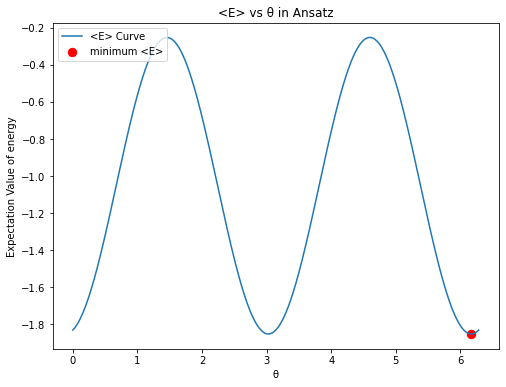

In [7]:
# Doing a scan of theta from 0-> 2pi and computing <E> at each step


#========================= Computing <E> at each theta value ===========================
theta_arr = np.linspace(0,2*np.pi,705)
E_arr = []
for i in range(len(theta_arr)):
    E_arr.append(expected(theta_arr[i], Hmol))
    

#====================== Finding which theta yields a minimum <E> =======================
theta_min = theta_arr[np.argmin(E_arr)]
E_min = min(E_arr)
ground_state = E_min + nuclear_repulsion

print('min theta =            ', theta_min)
print('min <E> =             ', E_min)
print('ground state energy = ', ground_state)

#========================= Plotting <E> as a function of theta =========================
plt.figure(figsize = (8,6))
plt.title('<E> vs \u03B8 in Ansatz')
plt.xlabel('\u03B8')
plt.ylabel('Expectation Value of energy')
plt.plot(theta_arr, E_arr, label = '<E> Curve')
plt.scatter([theta_min], [E_min], s = 70, c = 'r', label = 'minimum <E>')
plt.legend(loc = 'upper left')
plt.show()

By visual interpretation, we can infer that $\theta =  6.1671605784958725$ yields the minimum $<E>$

From here, we can calculate the ground state energy with $E_{ground} = min(\{E\}) + U_{nuclear}$

But wait, $min(\{E\})$ is the minimum energy eigenvalue, and we don't have that. But we do have $<E>$ AND we know that $<E> \geq min(\{E\})$.


Thus, if we minimize $<E> \rightarrow{} <E>_{min}$, then $<E>_{min} \approx min(\{E\})$. This is the crux of VQE

Therefore,

$E_{ground} \approx <E>_{min} + U_{nuclear}$

$E_{ground} \approx (-1.85119) + (0.70556)$

$E_{ground} \approx -1.1456273850693237$

And the true ground state energy is $-1.1457417$ ... Not bad!

# $\underline{3) \; Constructing  \; a \; Quantum \; Circuit \; for \; VQE}$

So far, we have not implimented VQE on an actual quantum circuit. This is an essential step since we need to map VQE to a quantum circuit so we can build an actual quantum algorithm.

Let's start by representing the unitary ansatz as a quantum circuit. Remember, we can do this because any unitary gate can be built out of other unitary gates. Thus, in theory, we should be able to build $\mathscr{U}$ using quantum gates, since all quantum gates (other than measurement operations) are unitary.

According to [1], below is the circuit equivalent of $\mathscr{U}$

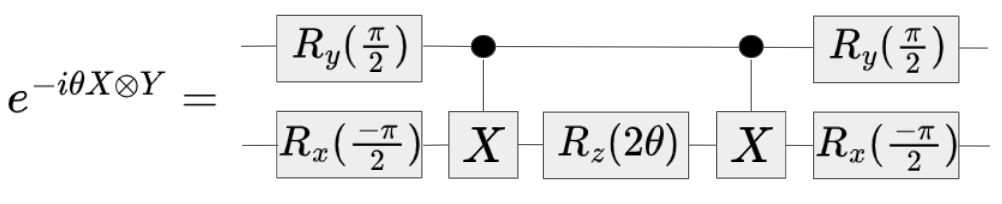

The Mathematica file *ansatz_circuit_construction.nb* shows a proof for why this circuit representation is true.

### Implimenting VQE in Qiskit

In [8]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Encoding Unitary Ansatz =================


def ansatz_circ(qc,theta):
    '''
    New ansatz function that appends ansatz quantum 
    circuit equivalent to qc for some parameter theta
    '''
    
    qc.ry(np.pi/2,q[0])  # Ry Rotation Gate
    qc.rx(-np.pi/2,q[1]) # Rx Rotation Gate
    qc.cx(q[0],q[1])     # CNOT Gate
    
    qc.rz(2*theta,q[1])  # Parameterized Rz Rotation Gate

    qc.cx(q[0],q[1])     # CNOT Gate
    qc.ry(np.pi/2,q[0])  # Ry Rotation Gate
    qc.rx(-np.pi/2,q[1]) # Rx Rotation Gate

    
ansatz_circ(qc,6.1671605784958725) # Copying & Pasting the optimal theta value that we found previously

qc.barrier()

# *** Insert Measurement Method Here to find <E> ***



print('______________Printing the Quantum Circuit______________')
print(qc)

# ================== Printing Wavefunction ============================
print('______________Printing the Wavefunction______________')

display(qf.PrintPsi(qc, extract = True)) # As a Pandas Dataframe

psi = qf.ReturnPsi(qc) # As a numpy array
print(psi)



# ================== Calculating the Expectation Value ================


def expected_circ(psi,H):
    '''
    A new expected function that takes in the wavefunction psi
    '''
    psi_dag = np.conjugate(np.transpose(psi))
    ans = psi_dag @ H @ psi
    return np.real(ans)


E_min_circ = expected_circ(psi,Hmol) # Calculating expectation value by <psi|H|psi>


print(' ')
print('______________Printing Expectation Value <E>_min______________')
print('<E>_min (Circuit)= ', E_min_circ)
print('<E>_min (Unitary Ansatz) = ', E_min)

______________Printing the Quantum Circuit______________
           ░ ┌─────────┐                         ┌─────────┐  ░ 
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ 
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░─
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ 
c: 2/═══════════════════════════════════════════════════════════
                                                                
______________Printing the Wavefunction______________


,State,Real Part,Imag Part,Magnitude,Phase,Probability
0,|00>,0.0,0.00000,0.00000,0.000000,0.000000
1,|01>,0.0,-0.11576,0.11576,-1.570796,0.013400
2,|10>,0.0,0.99328,0.99328,1.570796,0.986605
3,|11>,0.0,0.00000,0.00000,0.000000,0.000000


[0.+0.j      0.-0.11576j 0.+0.99328j 0.+0.j     ]
 
______________Printing Expectation Value <E>_min______________
<E>_min (Circuit)=  -1.8512072660697603
<E>_min (Unitary Ansatz) =  -1.8511969996693236


We see that the exponential matrix unitary approach to calculating $<E>_{min}$ matches the quantum circuit method to calculating $<E>_{min}$. Awesome! However, in the previous approach, we extracted the wavefunction from the quantum circuit and calculated the expectation value by hand using $<E> = <\psi|H|\psi>$ which is cheating! In real life, we can't just 'extract the wavefunction', we have to take a *measurement*. However, typical measurements in quantum circuit are associated with spin measurements, NOT energy expectation value measurements. So, we will have to do some clever pre-measurement operations such that when we take a spin measurement at the end, the measurements will correspond to some value of $<E>$. Such methods will be discussed below in section 4.

# $\underline{4) \;Quantum \; Measurement}$

To calculate $<E>$, we need some way to measure $<E>$. Unfortunately, quantum circuits are only capable of doing spin measurements. So, we need some way to implicitly measure $<E>$ through a pre-measurement quantum circuit scheme and measurement interpretation.


Remember, we have an analytical form for $E$ through our Hamiltonian

$H_{mol} = g_{0} I_{0} I_{1} + g_{1} Z_{0} + g_{2} Z_{1} + g_{3} Z_{0}Z_{1} + g_{4} Y_{0}Y_{1} + g_{5} X_{0} X_{1}$

Taking the expectation value on both sides

$<E> = g_{0} <I_{0} I_{1}> + g_{1} <Z_{0}> + g_{2} <Z_{1}> + g_{3} <Z_{0}Z_{1}> + g_{4} <Y_{0}Y_{1}> + g_{5} <X_{0} X_{1}>$

We can already reduce this a little bit since we know that $<I_{0} I_{1}> = 1$


$<E> = g_{0} + g_{1} <Z_{0}> + g_{2} <Z_{1}> + g_{3} <Z_{0}Z_{1}> + g_{4} <Y_{0}Y_{1}> + g_{5} <X_{0} X_{1}>$


So now, we don't need to measure $<E>$ directly, we just need to measure the expectation values of all of the other operators:

- $<Z_{0}>$
- $<Z_{1}>$
- $<Z_{0}Z_{1}>$
- $<Y_{0}Y_{1}>$
- $<X_{0} X_{1}>$

To measure Each of these expectation values, we need to append some pre-measurement quantum circuit to our current quantum circuit above, followed by some measurement.

Then we run a simulation to gather data to make a probability distribution.

Then, using ordinary statistics, we can calculate the expectation value for that operator.

Then, using the equation for $<E>$ above, we can subsitute in all operator expectation values to evaluate $<E>$.

### Coding Classical Circuit Simulator and Histogram Functions

In [104]:
# ================= Including Functions to 'correct' our simulators to display big endian notation ======================

def dual_sort(key, values):
    '''
    Sorts a list 'key' in ascending order and orders a list 'values' in the same arrangement as the sorted 'key'
    '''
    k=1
    while k!=0:
        k=0
        for i in range(len(key)-1):
            a = key[i]
            b = key[i+1]

            c = values[i]
            d = values[i+1]

            if b<a:
                k+=1
                key[i] = b
                key[i+1] = a

                values[i] = d
                values[i+1] = c

    return key, values


def bin_gen(number, num_qubits):
    '''
    Converts base 10 to binary
    '''
    bin1 = bin(number)[2:]
    L = num_qubits - len(bin1)
    bin2 = L*'0' + bin1
    return bin2


# Defining a function that uses a Classical Circuit Simulator to Simulate a Quantum Computer
def run_job(qc,q,shots):
    job = execute(qc, S_simulator, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)

    state = []
    freq  = []
    for name, value in counts.items():
        state.append(int(name[::-1],2))    
        freq.append(value)
    
    state1,freq1 = dual_sort(state,freq)
    
    state2 = []
    for i in range(len(state1)):
        state2.append( bin_gen(state1[i], int( len(q)) ))
    
    return state2, freq1



# Defining a function that plots a histogram of psuedo-experimental outcomes
def PlotHist(state, freq):
    # Plotting a Histogram of Measured Outcomes
    plt.figure(figsize = (6.5,4.5))
    plt.bar(state, freq)
    plt.title("Measurement Histogram")
    plt.xlabel('Quantum States')
    plt.ylabel('Frequency of States Measured')
    plt.xticks(rotation=70) 
    
    for x, y in zip(state, freq):
        plt.text(x, y, str(y), ha='center', va='bottom')
    
    plt.show()

### Prototyping Pre - Measurement (PM) Circuits & Measurement Options

Here, we need to encode a different pre-measurement circuit and measurement option for the expectation value of the operator we want to calculate. 

These PM circuit options are encoded in the following functions below

- ZI_measure(qc)
- IZ_measure(qc)
- ZZ_measure(qc)
- YY_measure(qc)
- XX_measure(qc)

We need to apply a pre-measurement scheme to get each operator ready for measurement in the spin-z basis.

Derivations for each of these pre-measurement circuits schemes are shown in my hand written notes *pm_and_measure.pdf*

In [105]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725)

# =========Pre-Measurement Circuits + Measurement Options =================


def ZI_measure(qc):
    qc.i(q[0])
    qc.measure(q[0],c[0])
    # Z Measurement on Qubit 0 
    
    
def IZ_measure(qc):
    qc.i(q[1])
    qc.measure(q[1],c[1])
    # Z Measurement on Qubit 1
    
    
def ZZ_measure(qc):
    qc.i(q[0])
    qc.i(q[1])
    
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    # Z Measurement on q0 and q1

def YY_measure(qc):
    qc.sdg(q[0])
    qc.sdg(q[1])
    qc.h(q[0])
    qc.h(q[1])
    
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    # Z Measurement on q0 and q1
    
def XX_measure(qc):
    qc.h(q[0])
    qc.h(q[1])
    
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    # Z Measurement on q0 and q1
    
print('_____ Needs a Measurement Operator to interpret results!______')
print(qc)

_____ Needs a Measurement Operator to interpret results!______
           ░ ┌─────────┐                         ┌─────────┐ 
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├─
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘
c: 2/════════════════════════════════════════════════════════
                                                             


### Let's go through each Measurement Protocol, run a pseudo-simulation, and Calculate Expectation Values

The expectation value of an operator $<M>$ can be calculated by $<M> = \mathbb{P}(|00>) + \mathbb{P}(|11>) - \mathbb{P}(|01>) - \mathbb{P}(|10>)$

See *expectation_values.pdf*

In [106]:
# Calculates the expectation values with measured spin data
def expected_circ2(state, freq, shots):
    probs = np.array(freq)/shots
    ex = 0
    for i in range(len(state)):
        if state[i] == '00':
            ex += probs[i]
        if state[i] == '11':
            ex += probs[i]
        if state[i] == '01':
            ex -= probs[i]
        if state[i] == '10':
            ex -= probs[i]
            
    return ex
    

#### 1) Measuring $<Z_{0}>$

           ░ ┌─────────┐                         ┌─────────┐  ░ ┌───┐┌─┐
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─┤ I ├┤M├
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░───────╫─
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░       ║ 
c: 2/═════════════════════════════════════════════════════════════════╩═
                                                                      0 
['00', '10']
[15, 985]


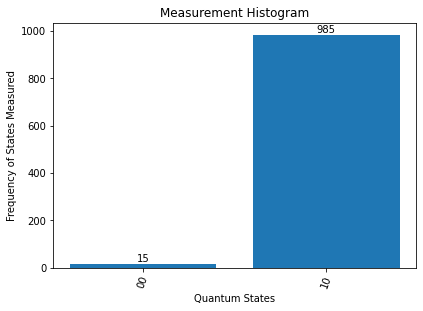

<Z0> =  -0.97


In [107]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725) # Angle set to optimal minimum

# ================= Measurement Options =================

qc.barrier()
ZI_measure(qc)

print(qc)

# ================= Running Classical Simulator =================

shots = 1000
state, freq = run_job(qc,q ,shots)

print(state)
print(freq)

PlotHist(state,freq)

ex_Z0 = expected_circ2(state, freq, shots) # Calcuates Expectation Value <Z0> with measured spin data
print('<Z0> = ', ex_Z0)

#### 2) Measuring $<Z_{1}>$

           ░ ┌─────────┐                         ┌─────────┐  ░         
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─────────
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ ┌───┐┌─┐
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░─┤ I ├┤M├
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ └───┘└╥┘
c: 2/═════════════════════════════════════════════════════════════════╩═
                                                                      1 
['00', '01']
[993, 7]


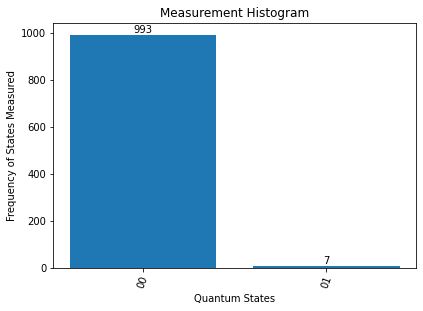

<Z1> =  0.986


In [108]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725) # Angle set to optimal minimum

# ================= Measurement Options =================

qc.barrier()
IZ_measure(qc)

print(qc)

# ================= Running Classical Simulator =================

shots = 1000
state, freq = run_job(qc, q,shots)

print(state)
print(freq)

PlotHist(state,freq)

ex_Z1 = expected_circ2(state, freq, shots) # Calcuates Expectation Value <Z1> with measured spin data
print('<Z1> = ', ex_Z1)

#### 3) Measuring $<Z_{0}Z_{1}>$

           ░ ┌─────────┐                         ┌─────────┐  ░ ┌───┐┌─┐   
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─┤ I ├┤M├───
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ ├───┤└╥┘┌─┐
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░─┤ I ├─╫─┤M├
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ └───┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════════════════════╩══╩═
                                                                      0  1 
['01', '10']
[11, 989]


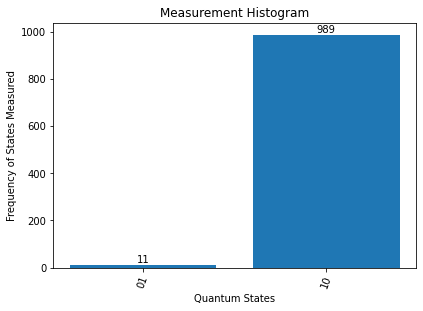

<ZZ> =  -1.0


In [109]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725) # Angle set to optimal minimum

# ================= Measurement Options =================

qc.barrier()
ZZ_measure(qc)

print(qc)

# ================= Running Classical Simulator =================

shots = 1000
state, freq = run_job(qc,q, shots)

print(state)
print(freq)

PlotHist(state,freq)

ex_ZZ = expected_circ2(state, freq, shots) # Calcuates Expectation Value <ZZ> with measured spin data
print('<ZZ> = ', ex_ZZ)

#### 4) Measuring $<Y_{0}Y_{1}>$

           ░ ┌─────────┐                         ┌─────────┐  ░ ┌─────┐┌───┐┌─┐»
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─┤ Sdg ├┤ H ├┤M├»
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ ├─────┤├───┤└╥┘»
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░─┤ Sdg ├┤ H ├─╫─»
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ └─────┘└───┘ ║ »
c: 2/════════════════════════════════════════════════════════════════════════╩═»
                                                                             0 »
«        
«q_0: ───
«     ┌─┐
«q_1: ┤M├
«     └╥┘
«c: 2/═╩═
«      1 
['00', '01', '10', '11']
[205, 292, 311, 192]


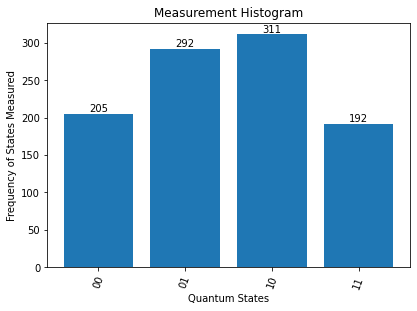

<YY> =  -0.20600000000000002


In [110]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725) # Angle set to optimal minimum

# ================= Measurement Options =================

qc.barrier()
YY_measure(qc)

print(qc)

# ================= Running Classical Simulator =================

shots = 1000
state, freq = run_job(qc,q, shots)

print(state)
print(freq)

PlotHist(state,freq)

ex_YY = expected_circ2(state, freq, shots) # Calcuates Expectation Value <YY> with measured spin data
print('<YY> = ', ex_YY)

#### 5) Measuring $<X_{0}X_{1}>$

           ░ ┌─────────┐                         ┌─────────┐  ░ ┌───┐┌─┐   
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─┤ H ├┤M├───
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ ├───┤└╥┘┌─┐
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(12.334) ├┤ X ├┤ Rx(-π/2) ├─░─┤ H ├─╫─┤M├
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ └───┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════════════════════╩══╩═
                                                                      0  1 
['00', '01', '10', '11']
[178, 316, 306, 200]


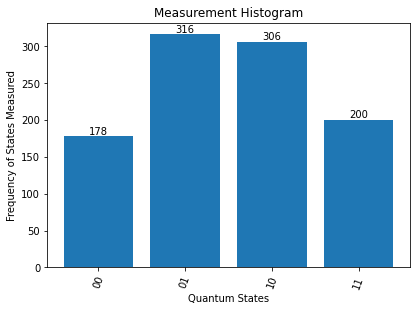

<XX> =  -0.244


In [111]:
# ============== Setting up Quantum Register ================
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc= QuantumCircuit(q,c)

# =================== State Preparation =====================

qc.x(q[1])   # State needs to start in the |01> state
qc.barrier()

# ================= Implimenting Unitary Ansatz =================

ansatz_circ(qc,6.1671605784958725) # Angle set to optimal minimum

# ================= Measurement Options =================

qc.barrier()
XX_measure(qc)

print(qc)

# ================= Running Classical Simulator =================

shots = 1000
state, freq = run_job(qc,q, shots)

print(state)
print(freq)

PlotHist(state,freq)

ex_XX = expected_circ2(state, freq, shots) # Calcuates Expectation Value <XX> with measured spin data
print('<XX> = ', ex_XX)

### Adding all the $<O>$'s to get the energy expectation value $<E>$

In [112]:
print('______All of our Operator Expectation Values______')
print('<Z0> = ', ex_Z0)
print('<Z1> = ', ex_Z1)
print('<ZZ> = ', ex_ZZ)
print('<YY> = ', ex_YY)
print('<XX> = ', ex_XX)

______All of our Operator Expectation Values______
<Z0> =  -0.97
<Z1> =  0.986
<ZZ> =  -1.0
<YY> =  -0.20600000000000002
<XX> =  -0.244


In [113]:
E_ex = g0 + g1*ex_Z0 + g2*ex_Z1 + g3*ex_ZZ + g4*ex_YY+ g5*ex_XX

print('True <E> = ', electronic_energy)

print('Experimental <E> = ', E_ex)

True <E> =  -1.851199124123644
Experimental <E> =  -1.8547592


Wow!! Amazing!!! :-)

We were able to calculate the energy expectation value $<E>$ with good precision only using quantum measurement. We officially did it without cheating i.e. using any np.linalg.eigh linear algebra tools!

Before celebrating too soon, notice that we did cheat just a *little bit*. Notice, we did all these expectation value computations already knowing that the minimum $<E>$ was at $\theta = 6.1671605784958725$. Remember, we figured this out classically by brute force in section 2.

Let's pretend we didn't know the optimal value of $\theta$ that minimizes $<E>$. How could we solve for the optimal $\theta$?

As quantum software engineers, we are well equipped with the tools of classical machine learning such as gradient descent that will help us search for $<E>_{min}$ efficiently.

This is where VQE becomes a hybrid quantum algorithm by encorporating quantum and classical tools.

# $\underline{5) \;Classical \; Optimization \; with \; Gradient \; Descent}$

### Putting it all together - Creating a Parameterized Quantum Circuit

In [114]:
def Return_E_expected(theta):
    
    def measurement_options(index):
        if index == 1:
            ZI_measure(qc)
        if index == 2:
            IZ_measure(qc)
        if index == 3:
            ZZ_measure(qc)
        if index == 4:
            YY_measure(qc)
        if index == 5:
            XX_measure(qc)
    
    g = [g0,g1,g2,g3,g4,g5]
    energy_ex = g0 # We get g0*<II> for free right at the start since <II> = 1 always
    
    for i in range(1,6): # Going through all measurement options
        
        # ============== Setting up Quantum Register ================
        q = QuantumRegister(2,'q')
        c = ClassicalRegister(2,'c')
        qc= QuantumCircuit(q,c)

        # =================== State Preparation =====================

        qc.x(q[1])   # State needs to start in the |01> state
        qc.barrier()

        # ================= Implimenting Unitary Ansatz =================

        ansatz_circ(qc,theta) # Parameterizing the quantum circuit

        
        # ================= Measurement Options =================
        
        measurement_options(i)
        
#         print(qc) # Uncomment to see each quantum circuit being ran
        # ================= Running Classical Simulator =================

        shots = 1000
        state, freq = run_job(qc,q, shots)

        operator_ex = expected_circ2(state, freq, shots) # Calcuates Expectation Value of an operator <O>
        
        energy_ex += operator_ex*g[i]
        
    return energy_ex

### Quick Sanity Checks

Ok! So far, we've summarized a lot in one block of code.


Let's check to see that Return_E_expected(6.1671605784958725) still returns a value close to the true expectation value of $<E>_{true} = -1.851199124123644$

In [115]:
print('<E> experimental = ',Return_E_expected(6.1671605784958725))

<E> experimental =  -1.8473994


As Expected, this function appears to still work!

Let's see if we can recover the energy expectation value curve profile from section 2 by doing a rough scan of $\theta$ from $0$ to $2\pi$

In [116]:
theta_arr2 = np.linspace(0,2*np.pi,30)
E_arr2 = []

for i in range(len(theta_arr2)):
    E_arr2.append( Return_E_expected(theta_arr2[i])  )

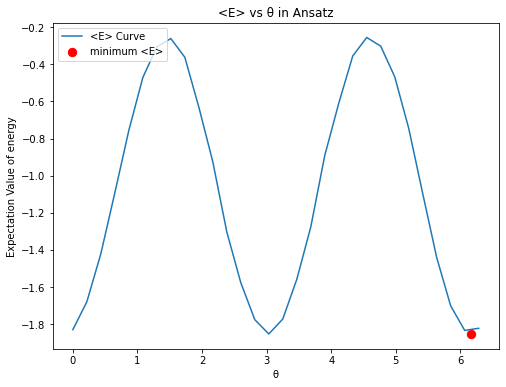

In [117]:
plt.figure(figsize = (8,6))
plt.title('<E> vs \u03B8 in Ansatz')
plt.xlabel('\u03B8')
plt.ylabel('Expectation Value of energy')
plt.plot(theta_arr2, E_arr2, label = '<E> Curve')
plt.scatter([theta_min], [E_min], s = 70, c = 'r', label = 'minimum <E>')
plt.legend(loc = 'upper left')
plt.show()

Phew!! Great! Everything appears to be working properly within our Return_E_expected(theta) parameterized quantum circuit.

We obtained consistent results with everything we've coded up previously, so that is a good sign to move forward with our classical optimization scheme to find the optimal $\theta$ (assuming we don't know it beforehand -- which is usually the case in real life)

### Classical Machine Learning


We will use a gradient descent function to minimimize the energy expectation value by sequentially tweaking the parameter $\theta$ in our parameterized quantum circuit.


In [158]:
# A gradient descent function that minimizes some function f
def grad_descent(f, guess, lr):
    dx = 0.01
    eps = 0.0001
    
    '''    
    f = function you want to minimize
    guess = an initial guess
    lr = the learning rate
    '''
    x = guess
    diff = f(x+dx) - f(x)
    
    while abs(diff) > eps:
        diff = f(x + dx) - f(x)
        df_dx = diff/dx
        x -= lr*df_dx
    
    return x   


# ============ Performing gradient descent on our parameterized quantum circuit ============ 
theta_opt = grad_descent(Return_E_expected, 5.5, 0.1)
E_ex_opt = Return_E_expected(theta_opt)



# ============ Comparing obtained results with the true optimum ============ 

# Obtained Results
print('theta_opt = ', theta_opt)
print('<E>_opt = ', E_ex_opt)

print(' ')

# The True Results
print('theta_opt_true = ', 6.1671605784958725)
print('<E>_opt_true = ', -1.851199124123644)

theta_opt =  6.222431999999971
<E>_opt =  -1.8458746000000001
 
theta_opt_true =  6.1671605784958725
<E>_opt_true =  -1.851199124123644


Now, we can officially say that we've sucessfully implimented the VQE without any cheating -- Meaning, the above uses no linear algebra tools from any Python packages, nor does it rely on our prior knowledge of the correct result. 

This concludes the Variational Eigensolver Tutorial.



# Bibliography


[1] J. Goings, “Variational Quantum Eigensolver (VQE) example,” Joshua Goings, https://joshuagoings.com/2020/08/20/VQE/ (accessed Nov. 3, 2023). 

[2] Qiskit, “VQE zero to hero,” YouTube, https://www.youtube.com/watch?v=TUFovZsBcW4 (accessed Nov. 3, 2023). 

[3] “A tutorial on quantum approximate optimization algorithm (Oct 2020). part 1: Theory,” YouTube, https://www.youtube.com/watch?v=AOKM9BkweVU&amp;t=1763s (accessed Nov. 3, 2023). 

[4] “Building variational Quantum Eigensolver from scratch,” Variational Qauntum Eigensolver, https://obliviateandsurrender.github.io/blogs/vqe.html#:~:text=It%20is%20done%20by%20applying,do%20a%20normal%20basis%20measurement. (accessed Nov. 10, 2023). 

[5] P. J. J.  O’Malley, Scalable quantum simulation of molecular energies, https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007 (accessed Nov. 10, 2023). 